In [4]:
from Favorfit_remove_bg import inference as remove_bg

rmbg_model = remove_bg.call_model("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/remove_bg/remove_bg.pth", device="cuda")

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
import torch
from diffusers import StableDiffusionControlNetPipeline, DDIMScheduler, AutoencoderKL, ControlNetModel
from diffusers.utils import make_image_grid
from PIL import Image

from IPAdapter.ip_adapter import IPAdapter
from utils import *

In [13]:
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "./IPAdapter/models/image_encoder/"
ip_ckpt = "./IPAdapter/models/ip-adapter_sd15.bin"
device = "cuda"

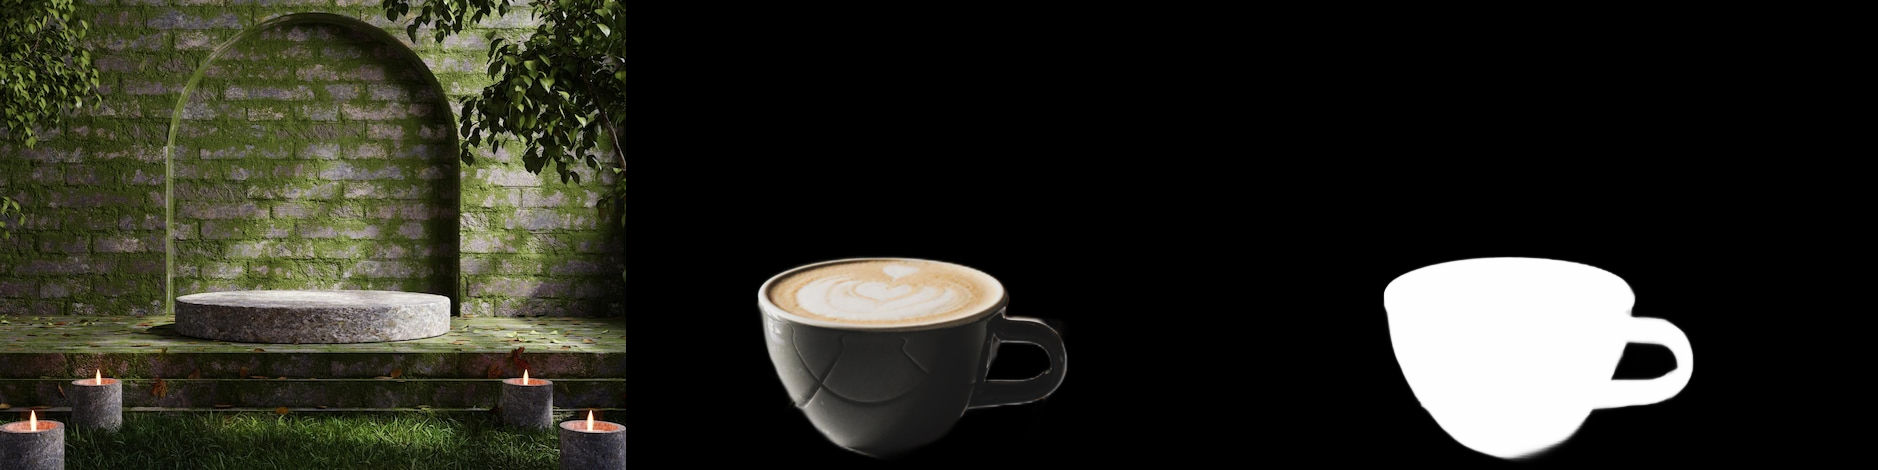

In [17]:
# read image prompt
style = Image.open("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/Favorfit_backoffice/inference_test_image/shuffle.jpg")
# depth_map = Image.open("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/Favorfit_backoffice/inference_test_image/object.png")
init_image = Image.open("/media/mlfavorfit/sdb/contolnet_dataset/control_net_train/conditioning_images/cup_7976_cupof.jpg").resize((512,512))
mask = remove_bg.inference(init_image, rmbg_model)
make_image_grid([style, init_image, mask], 1, 3)

In [18]:
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

# load controlnet
controlnet_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/controlnet/control_favorfit_outpaint_v2.safetensors"
controlnet = ControlNetModel.from_single_file(controlnet_model_path, torch_dtype=torch.float16, use_safetensor=True)
# load SD pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 10.68it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [19]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


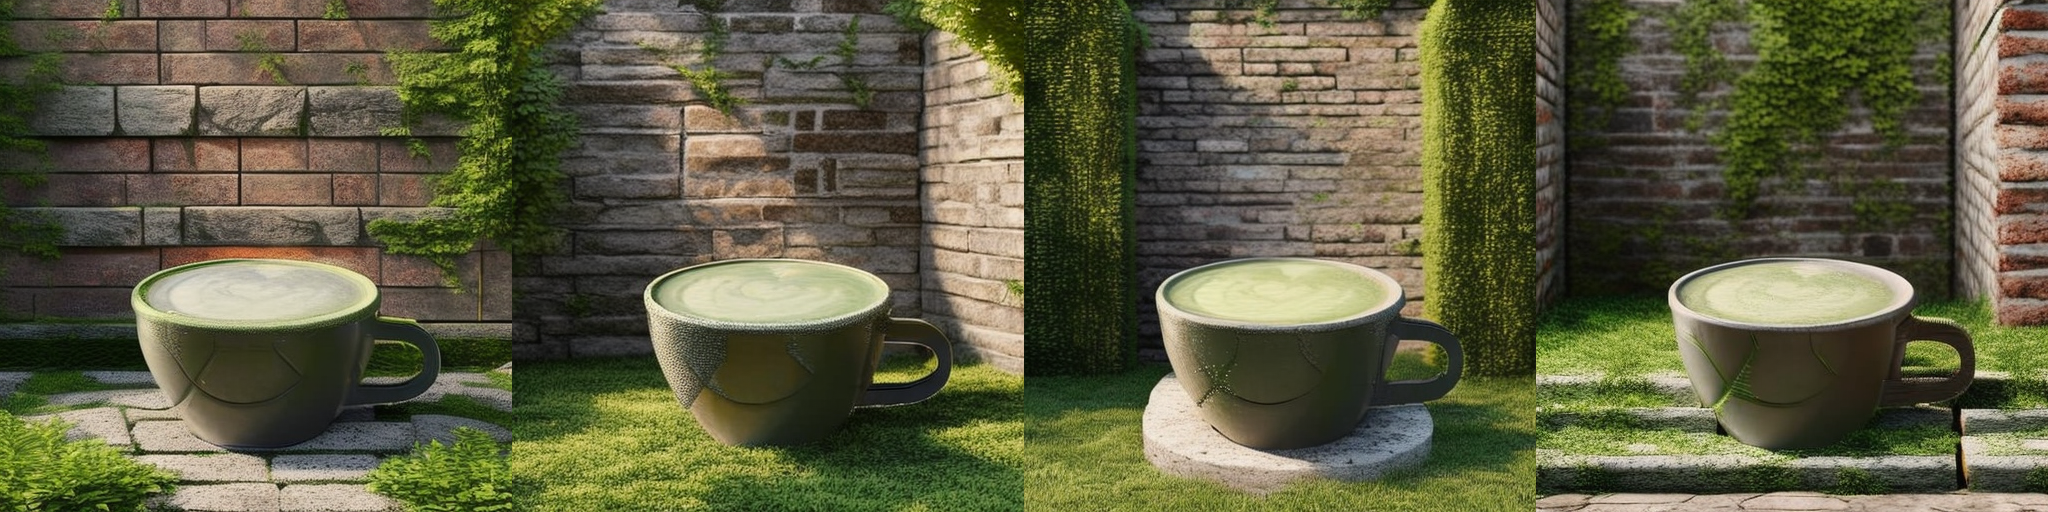

In [28]:
# generate image variations
images = ip_model.generate(pil_image=style, 
                           image=init_image, 
                           num_samples=4, 
                           num_inference_steps=50, 
                           seed=32, 
                           prompt="best quality, high quality, a coffee mug cup", 
                           scale=1.0)
make_image_grid(images, 1, 4)

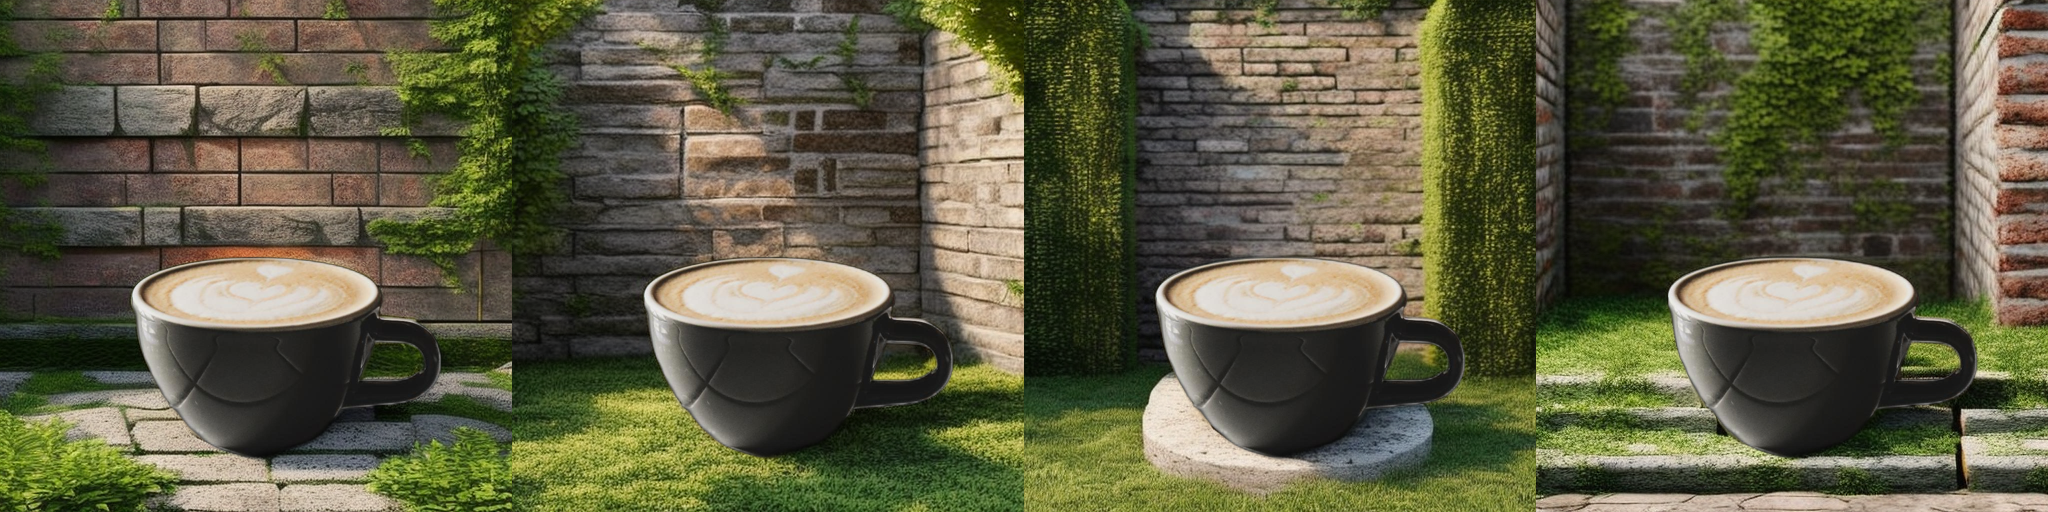

In [29]:
composed_images = [composing_image(cur, init_image, mask) for cur in images]
make_image_grid(composed_images, 1, 4)